# Supernova distances and redshifts 
Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

# Part 1



####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [139]:
from astroML.datasets import generate_mu_z
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import LinearRegression
from astroML.linear_model import NadarayaWatson
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from scipy.optimize import fmin_cobyla
from scipy.optimize import curve_fit
from scipy.stats import norm

import emcee
import dynesty
from dynesty.utils import resample_equal
import scipy
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
import corner
import time
%matplotlib inline
%config InlineBackend.figure_format='retina'

(35.0, 50.0)

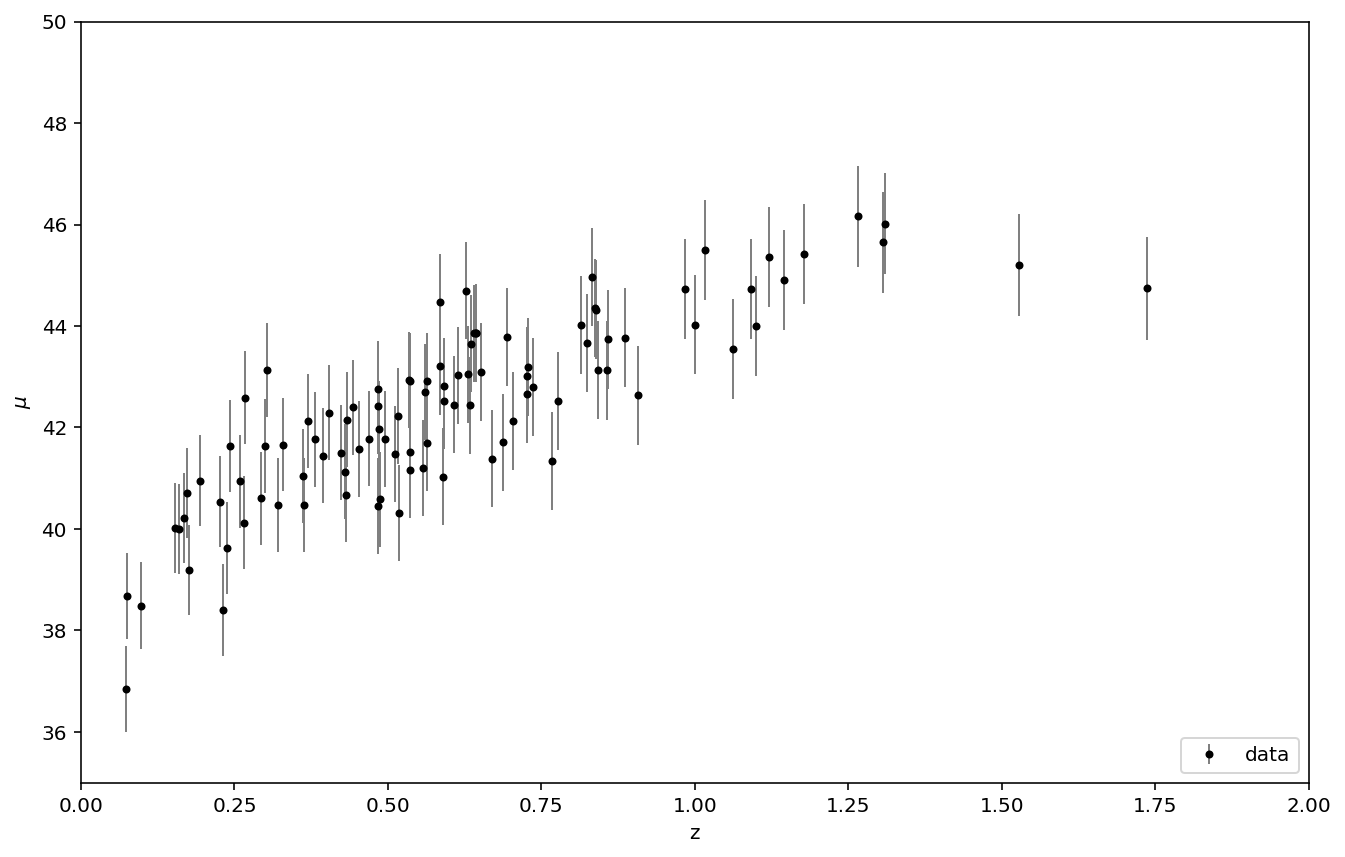

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)
plt.figure(figsize=(11, 7))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [3]:
matrix_val = np.array((z_sample, mu_sample))
dataset_ = matrix_val.transpose()

In [4]:
dataset_corr_ = dataset_[dataset_[:, 0].argsort()]
z = np.linspace(0.01, 2, 1000)

In [5]:
# cv split
X_train, X_test, ydy_train, ydy_test = train_test_split(dataset_corr_[:, 0], np.array([dataset_corr_[:, 1],dmu]).T, test_size=0.2, random_state=1)  # ydy to have also errors to work with
Y_train, dy_train = ydy_train.T
Y_test,dy_test = ydy_test.T

In [6]:
def error(X, y, regressor):
    
    return np.sqrt( np.sum(( y - regressor.predict(X[:, np.newaxis]) )**2) / len(X) )  # returns only one number

def fitanderror(regressor): # function of only regressor, data is const
    
    regressor.fit(X_train[:, None], Y_train, dy_train)
    error_train = error(X_train, Y_train, regressor)
    error_test  = error(X_test, Y_test, regressor)
    
    return error_train, error_test

## Linear regression

In [7]:
model = LinearRegression()
model.fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1][:, None], dmu)
mu_pred = model.predict(dataset_corr_[:, 0][:, None])

print("alpha:", model.coef_, "; intercept:", model.intercept_)

alpha: [[4.6421595]] ; intercept: [39.57112419]


(35.0, 50.0)

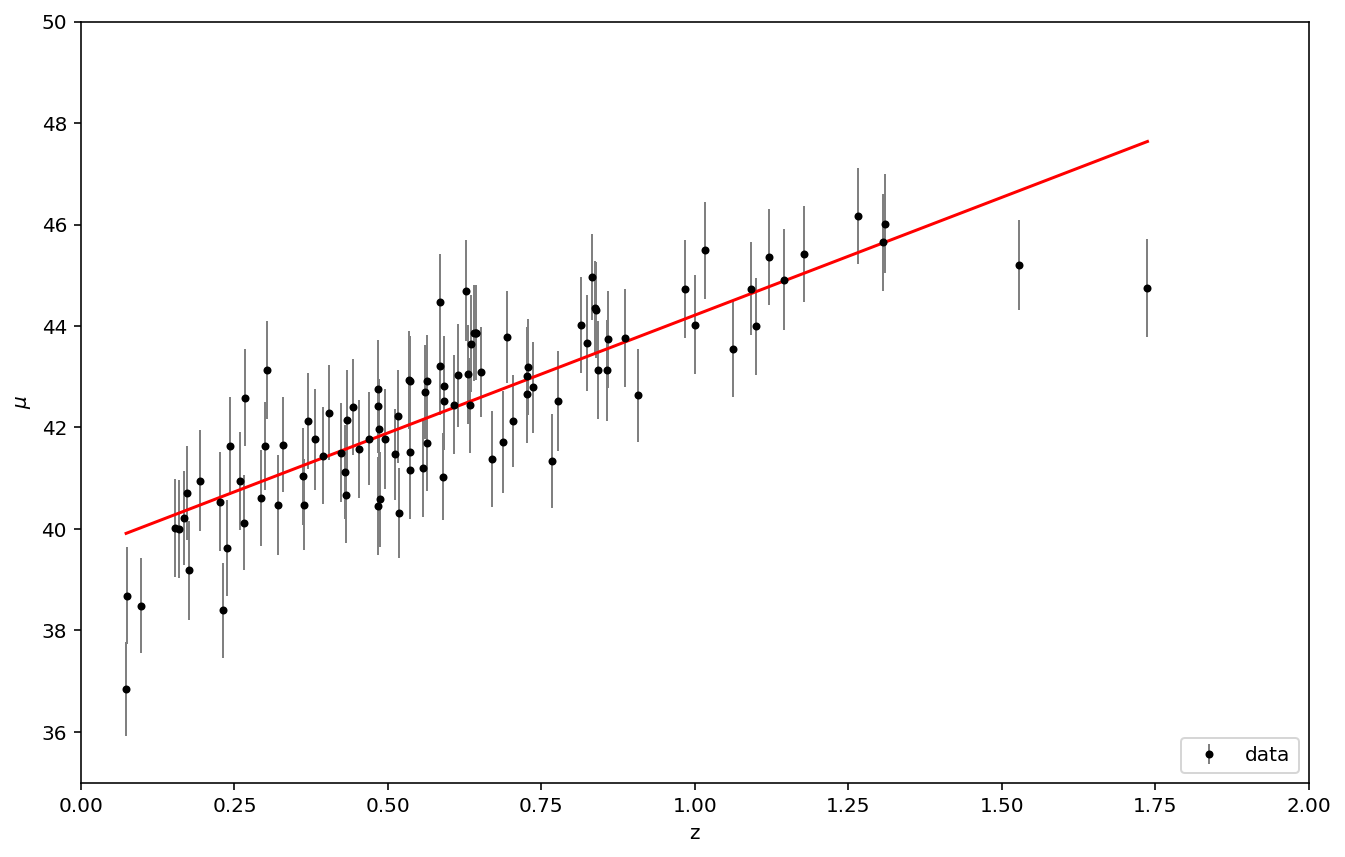

In [8]:
plt.figure(figsize=(11, 7))
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(dataset_corr_[:, 0], mu_pred, c='red')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

## Polynomial regression 

In [9]:
model_poly = {}
mu_pred_poly = {}
n_constraints = {}
 
for i in range(1, 7): 

    #print(i)
    degree = i
    model_poly[f'{i}'] = PolynomialRegression(degree) # fit 2nd degree polynomial
    model_poly[f'{i}'].fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1], dmu)

    mu_pred_poly[f'{i}'] = model_poly[f'{i}'].predict(z[:, None])
    n_constraints[f'{i}'] = degree + 1

#print(model_poly.coef_)

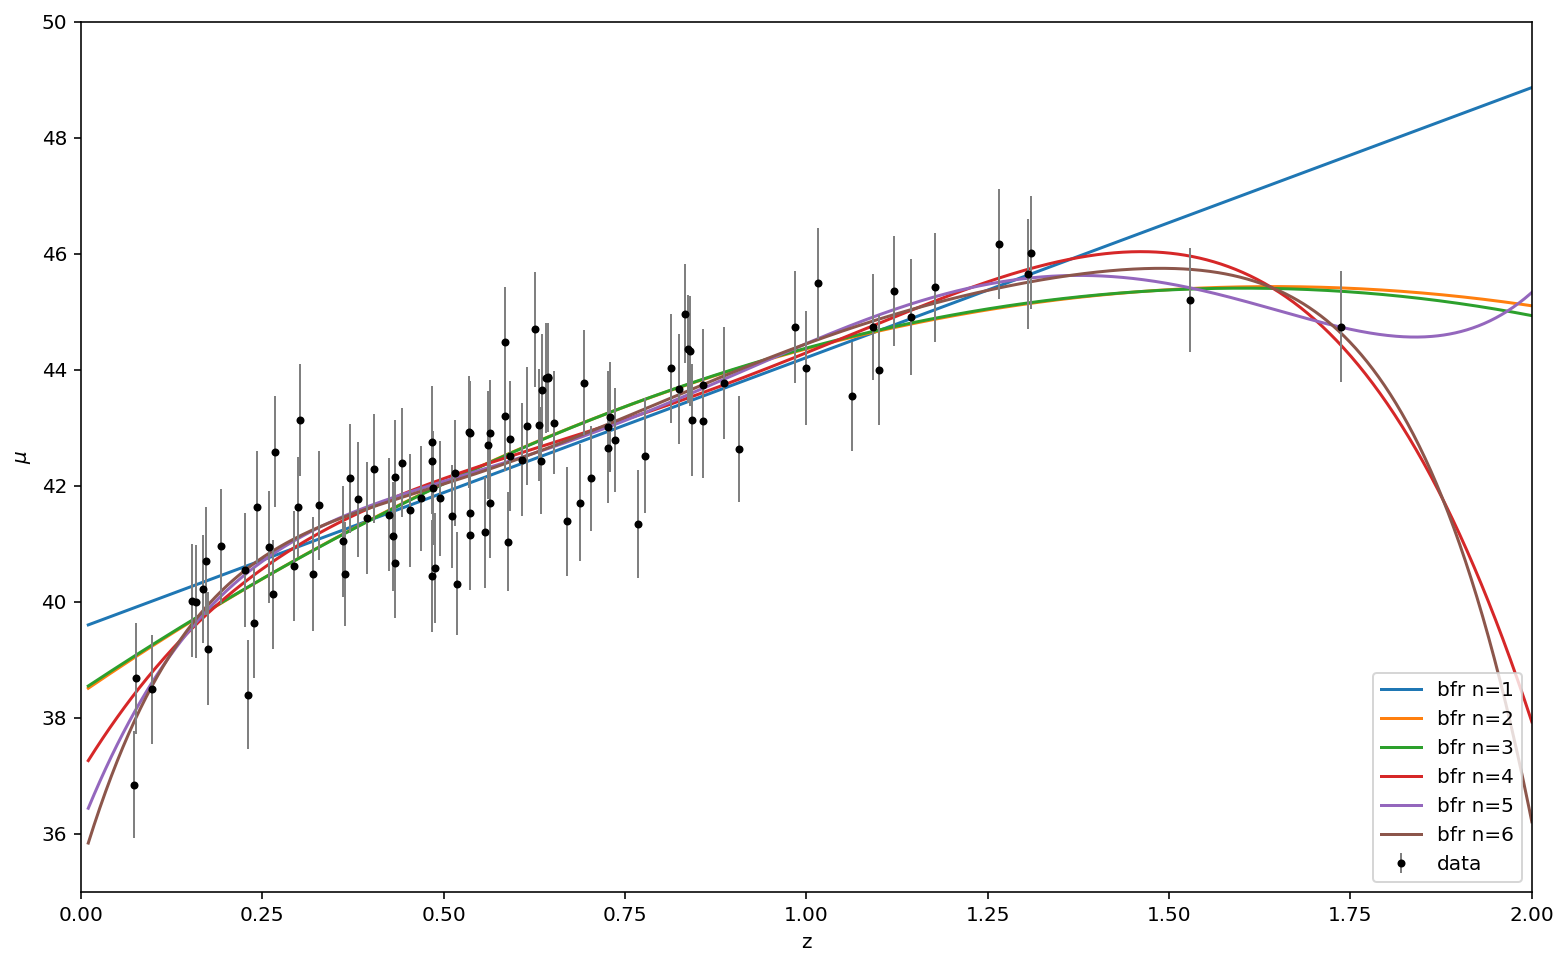

In [10]:
plt.figure(figsize=(13, 8))

for i in np.arange(1, 7):  # best plotting option taken from solutions
    
    plt.plot(z, mu_pred_poly[f'{i}'], label='bfr n='+str(i))
    
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

My intuition is that $n = 3$ or $n = 2$ are good descriptions of the data I am studying. However, I am going to double check via cross validation.

### Cross validation

Version 1:

In [11]:
model_cv = PolynomialRegression()
degrees = np.arange(1, 7)

cv_model = GridSearchCV(estimator=model_cv,
                        param_grid={'degree': degrees}, cv= 6, scoring='neg_mean_squared_error')  # , scoring='neg_mean_squared_error'

results = cv_model.fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1]);

In [12]:
results.cv_results_

{'mean_fit_time': array([0.00130486, 0.00232116, 0.00092971, 0.00093508, 0.00142002,
        0.00093198]),
 'std_fit_time': array([2.93363284e-04, 2.25019270e-03, 1.56010593e-04, 8.12233233e-05,
        6.42019637e-04, 1.41526548e-04]),
 'mean_score_time': array([0.00062764, 0.00272302, 0.00061882, 0.00070691, 0.00086967,
        0.00055587]),
 'std_score_time': array([4.88325156e-05, 3.65757834e-03, 1.18694206e-04, 1.88689742e-04,
        3.83933393e-04, 5.73264488e-05]),
 'param_degree': masked_array(data=[1, 2, 3, 4, 5, 6],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'degree': 1},
  {'degree': 2},
  {'degree': 3},
  {'degree': 4},
  {'degree': 5},
  {'degree': 6}],
 'split0_test_score': array([  -2.23893695,   -1.2158157 ,   -3.44956779,   -3.26413179,
         -10.67839298, -114.3127786 ]),
 'split1_test_score': array([-0.63803912, -0.72278967, -0.73943022, -0.59582181, -0.56767421,
        -0.55987

In [13]:
print("best estimator:", results.best_params_)
print("best estimator score:", results.best_score_)

best estimator: {'degree': 2}
best estimator score: -1.1802869099165691


Version 2: 

In [14]:
e_train, e_test= [], []
    
for i in np.arange(1, 7): 
    
    model_cv = PolynomialRegression(degree=i)
    
    err_train, err_test = fitanderror(model_cv)
    e_train.append(err_train)
    e_test.append(err_test)

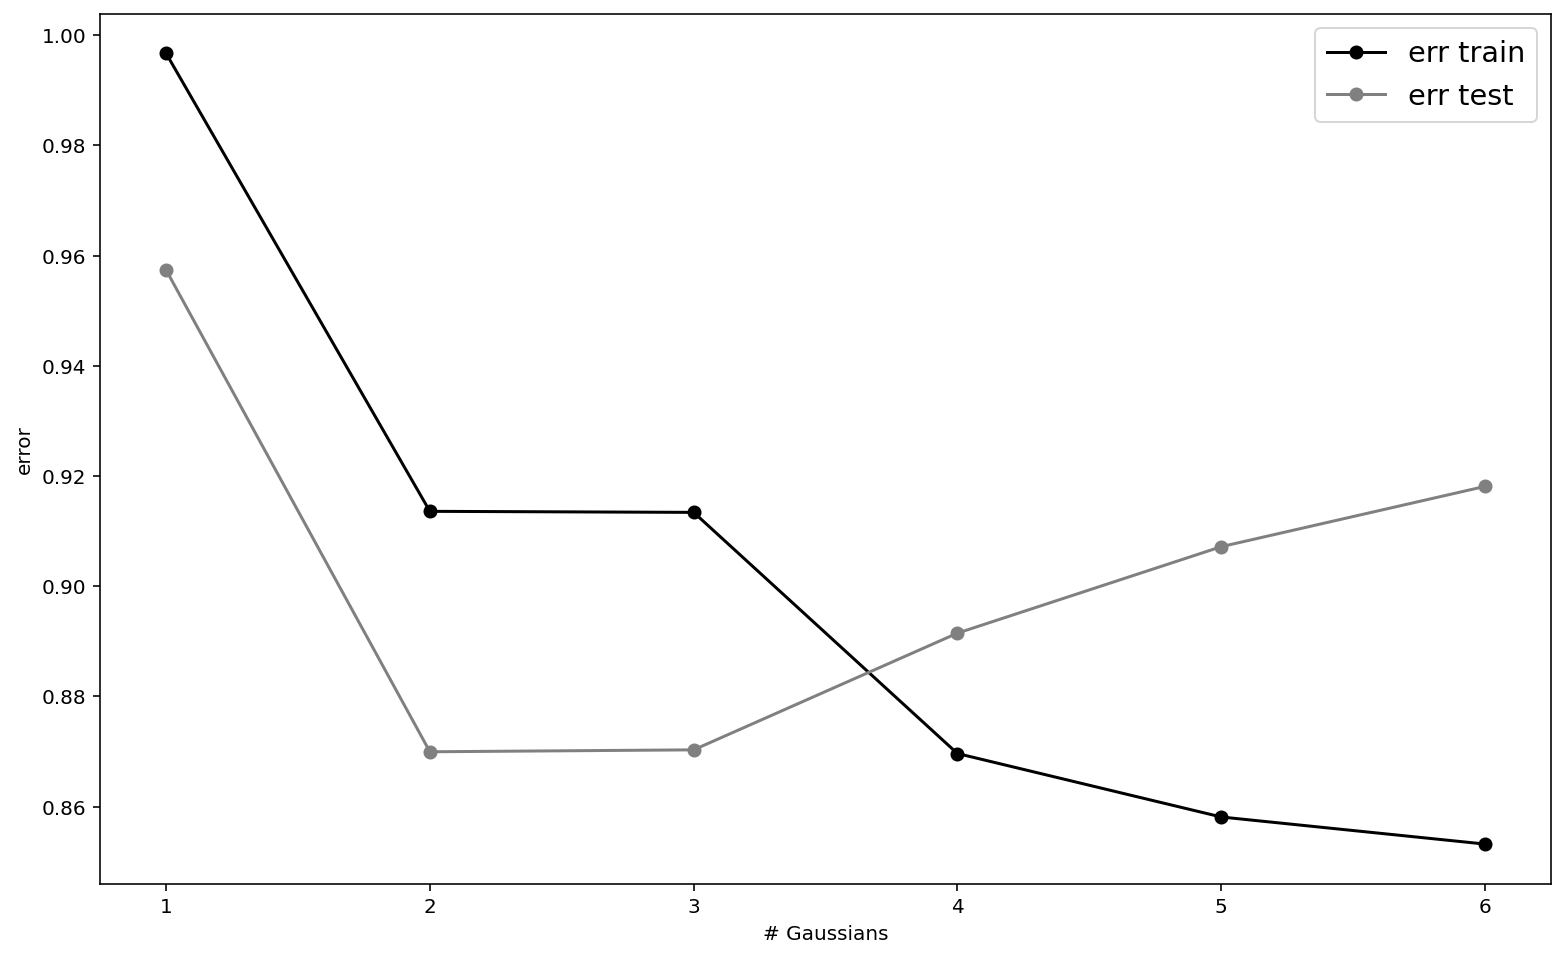

In [15]:
plt.figure(figsize=(13, 8))
plt.plot(np.arange(1, 7), e_train, marker='o', label='err train', c='black')
plt.plot(np.arange(1, 7), e_test, marker='o', label='err test', c='grey')
plt.ylabel('error')
plt.xlabel('# Gaussians')
plt.legend(loc='upper right', fontsize = 'x-large'); 

In [16]:
n_degree = np.arange(1,7)
print("n_gauss:", float(n_degree[np.argmin(np.abs(np.array(e_test) - np.array(e_train)))]))

n_gauss: 4.0


## Basis function regression

In [17]:
model_bfr = {}
mu_pred_bfr = {}
 
for i in np.arange(1,20)[1::4]: 

    # mean positions of the 10 Gaussians in the model
    X_gridtest = np.linspace(0, 10, i)[:, None]

    # widths of these Gaussians
    sigma_test = 0.1
    
    model_bfr = BasisFunctionRegression(basis_func='gaussian', mu=X_gridtest, sigma=sigma_test)
    model_bfr.fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1], dmu)

    mu_pred_bfr[f'{i}'] = model_bfr.predict(z[:, None])

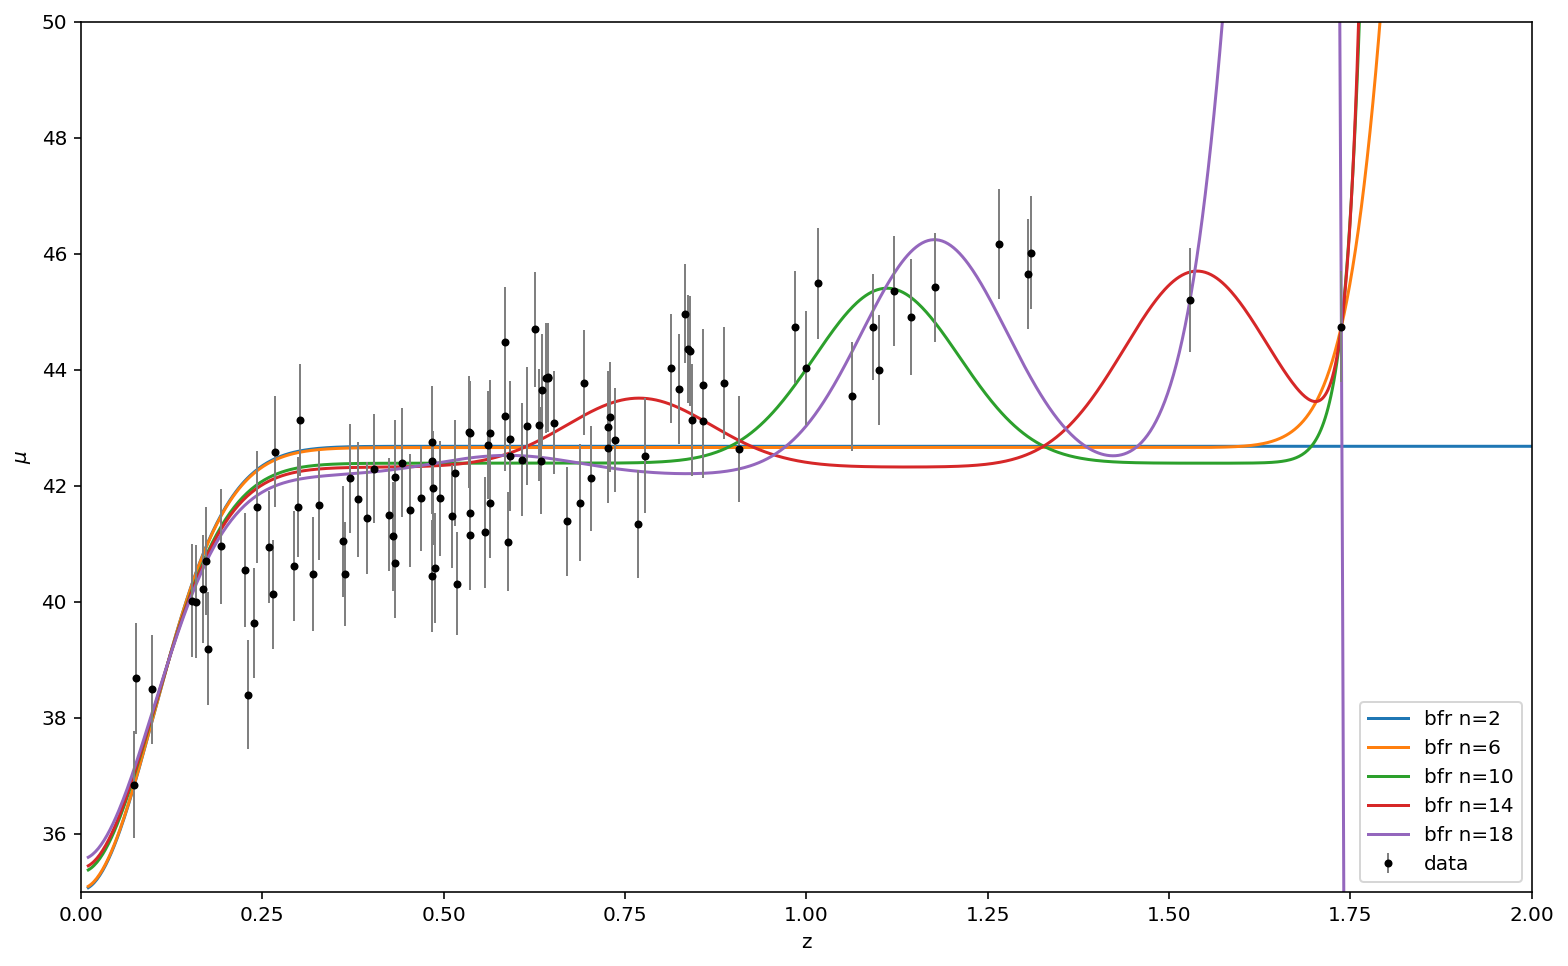

In [18]:
plt.figure(figsize=(13, 8))

for i in np.arange(1,20)[1::4]:  # best plotting option taken from solutions
    
    plt.plot(z, mu_pred_bfr[f'{i}'], label='bfr n='+str(i))
    
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In this case passing $X_{grid}$ does not work in GridCV:

In [19]:
e_train, e_test= [], []
    
for i in np.arange(1,10): 

    # mean positions of the 10 Gaussians in the model
    X_gridtest = np.linspace(0, 1, i)[:, None]

    # widths of these Gaussians
    sigma_test = 0.1
    
    model_bfr = BasisFunctionRegression(basis_func='gaussian', mu=X_gridtest, sigma=sigma_test)
    
    err_train, err_test = fitanderror(model_bfr)
    e_train.append(err_train)
    e_test.append(err_test)

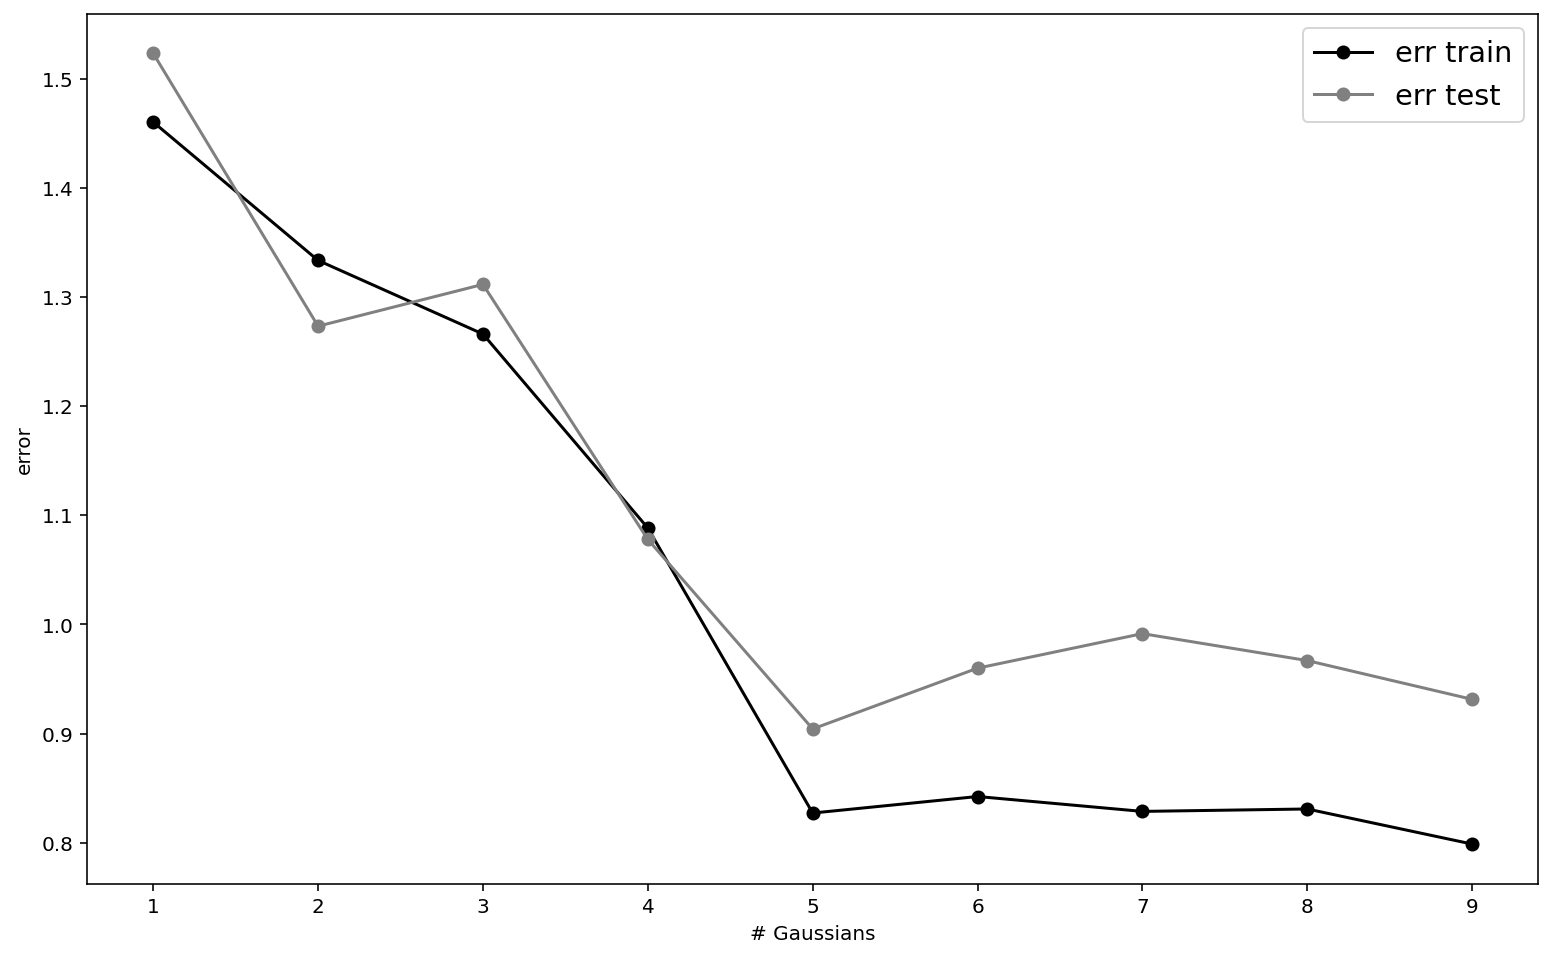

In [20]:
plt.figure(figsize=(13, 8))
plt.plot(np.arange(1,10), e_train, marker='o', label='err train', c='black')
plt.plot(np.arange(1,10), e_test, marker='o', label='err test', c='grey')
plt.ylabel('error')
plt.xlabel('# Gaussians')
plt.legend(loc='upper right', fontsize = 'x-large'); 

Find the best by minimizing the CV error: 

In [21]:
n_gauss = np.arange(1,10)
print("n_gauss:", float(n_gauss[np.argmin(np.abs(np.array(e_test) - np.array(e_train)))]))

n_gauss: 4.0


## Kernel regression

In [22]:
model_ker = {}
mu_pred_ker = {}

hs = [0.01, 0.03, 0.07, 0.1, 0.15, 0.2, 0.3]
index = 0
    
for i in hs:
    
    model_ker = NadarayaWatson(kernel='gaussian', h=i)
    model_ker.fit(dataset_corr_[:, 0][:, np.newaxis], dataset_corr_[:, 1])

    mu_pred_ker[f'{index}'] = model_ker.predict(z[:, None])
    
    index = index + 1

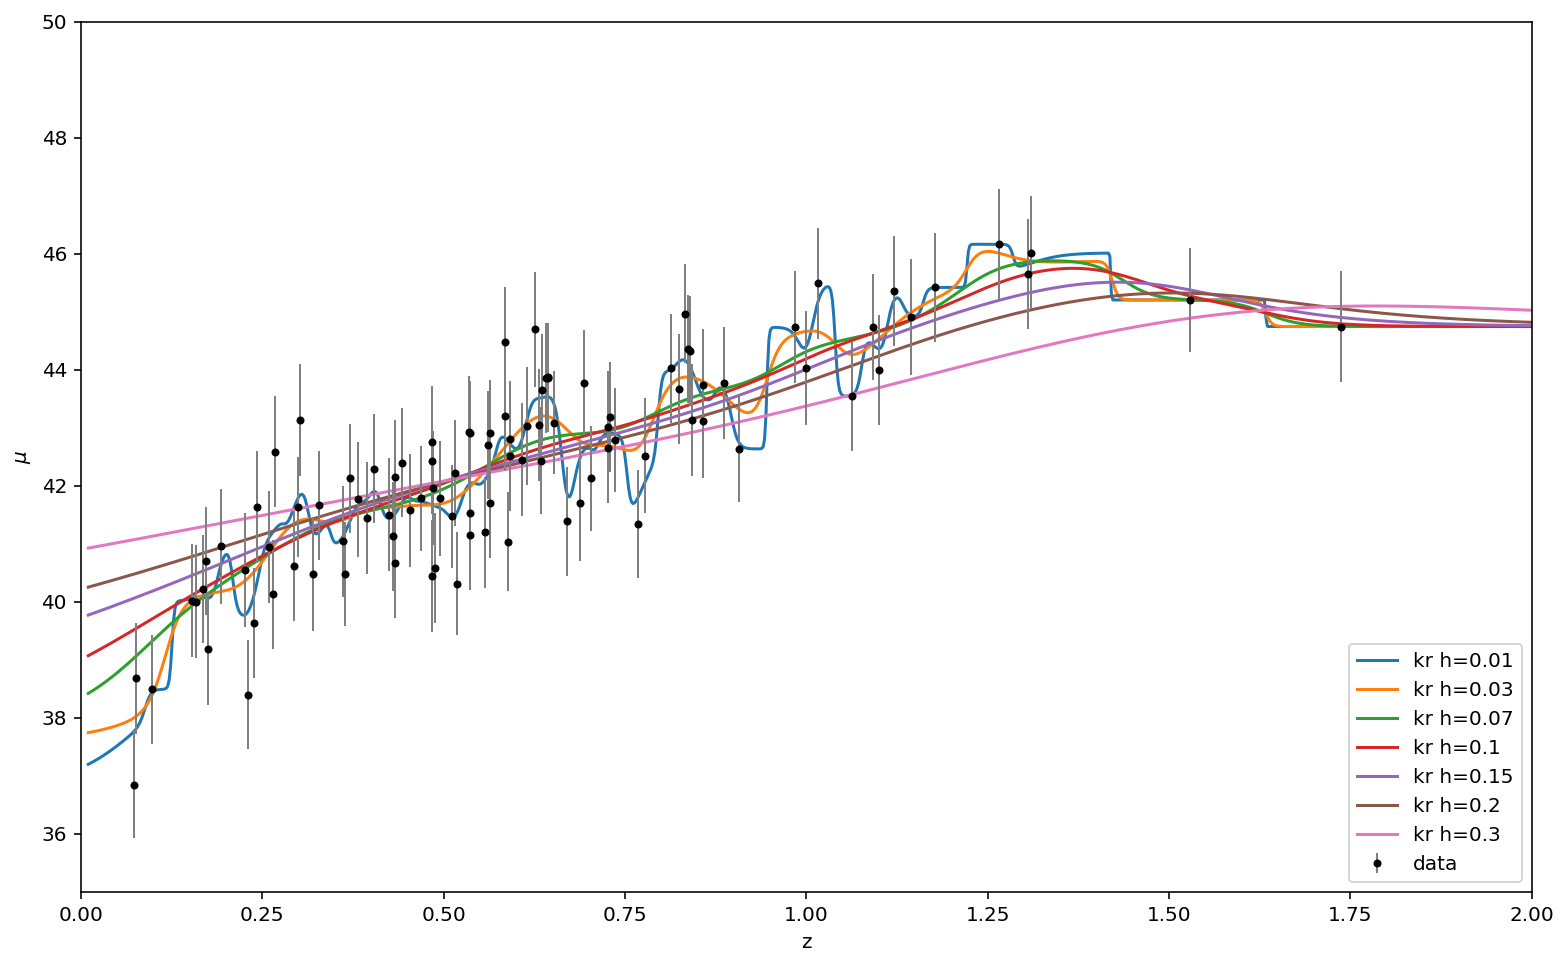

In [23]:
plt.figure(figsize=(13, 8))

for i in range(0, 7):  # best plotting option taken from solutions
    
    plt.plot(z, mu_pred_ker[f'{i}'], label='kr h='+str(hs[i]))
    
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In [24]:
e_train, e_test= [], []
    
for i in hs: 
    
    model_ker = NadarayaWatson(kernel='gaussian', h=i)  # bandwidth for kernel-estimate
    
    err_train, err_test = fitanderror(model_ker)
    e_train.append(err_train)
    e_test.append(err_test)

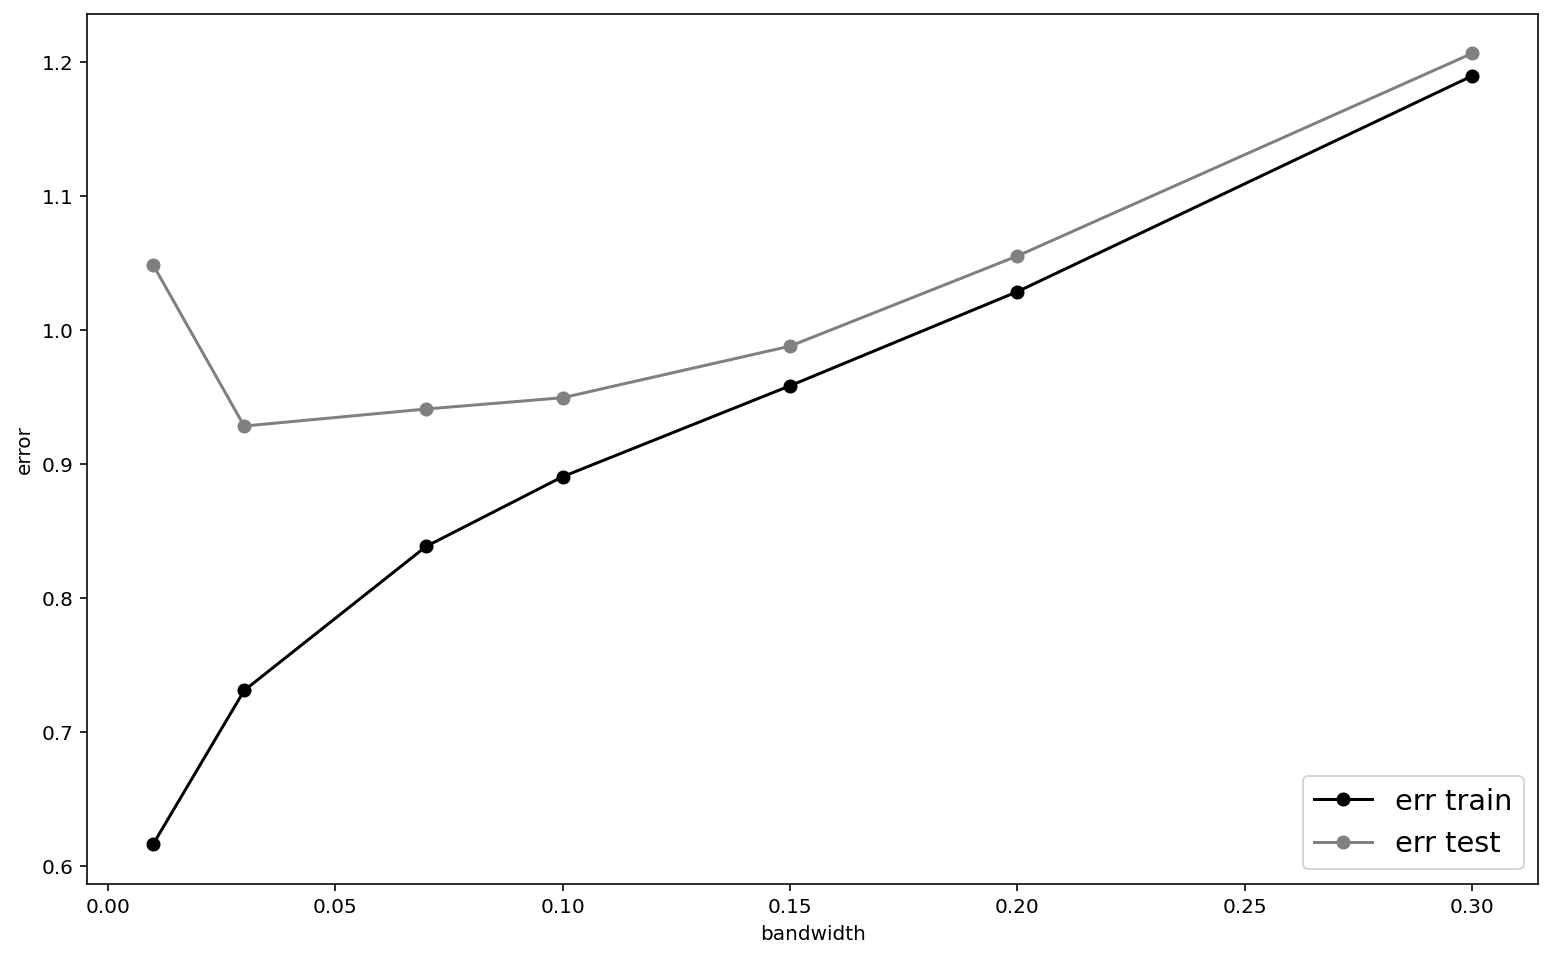

In [25]:
plt.figure(figsize=(13, 8))
plt.plot(hs, e_train, marker='o', label='err train', c='black')
plt.plot(hs, e_test, marker='o', label='err test', c='grey')
plt.ylabel('error')
plt.xlabel('bandwidth')
plt.legend(loc='lower right', fontsize = 'x-large'); 

In [26]:
print("n_gauss:", float(hs[np.argmin(np.abs(np.array(e_test) - np.array(e_train)))]))

n_gauss: 0.3


# Part 2

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

## GPR

In [27]:
kernel_s = [1 * kernels.RBF(0.01),  1 * kernels.RBF(0.1), 1 * kernels.RBF(0.5), 1 * kernels.RBF(1)]# , (1/0.5, 1/0.5)

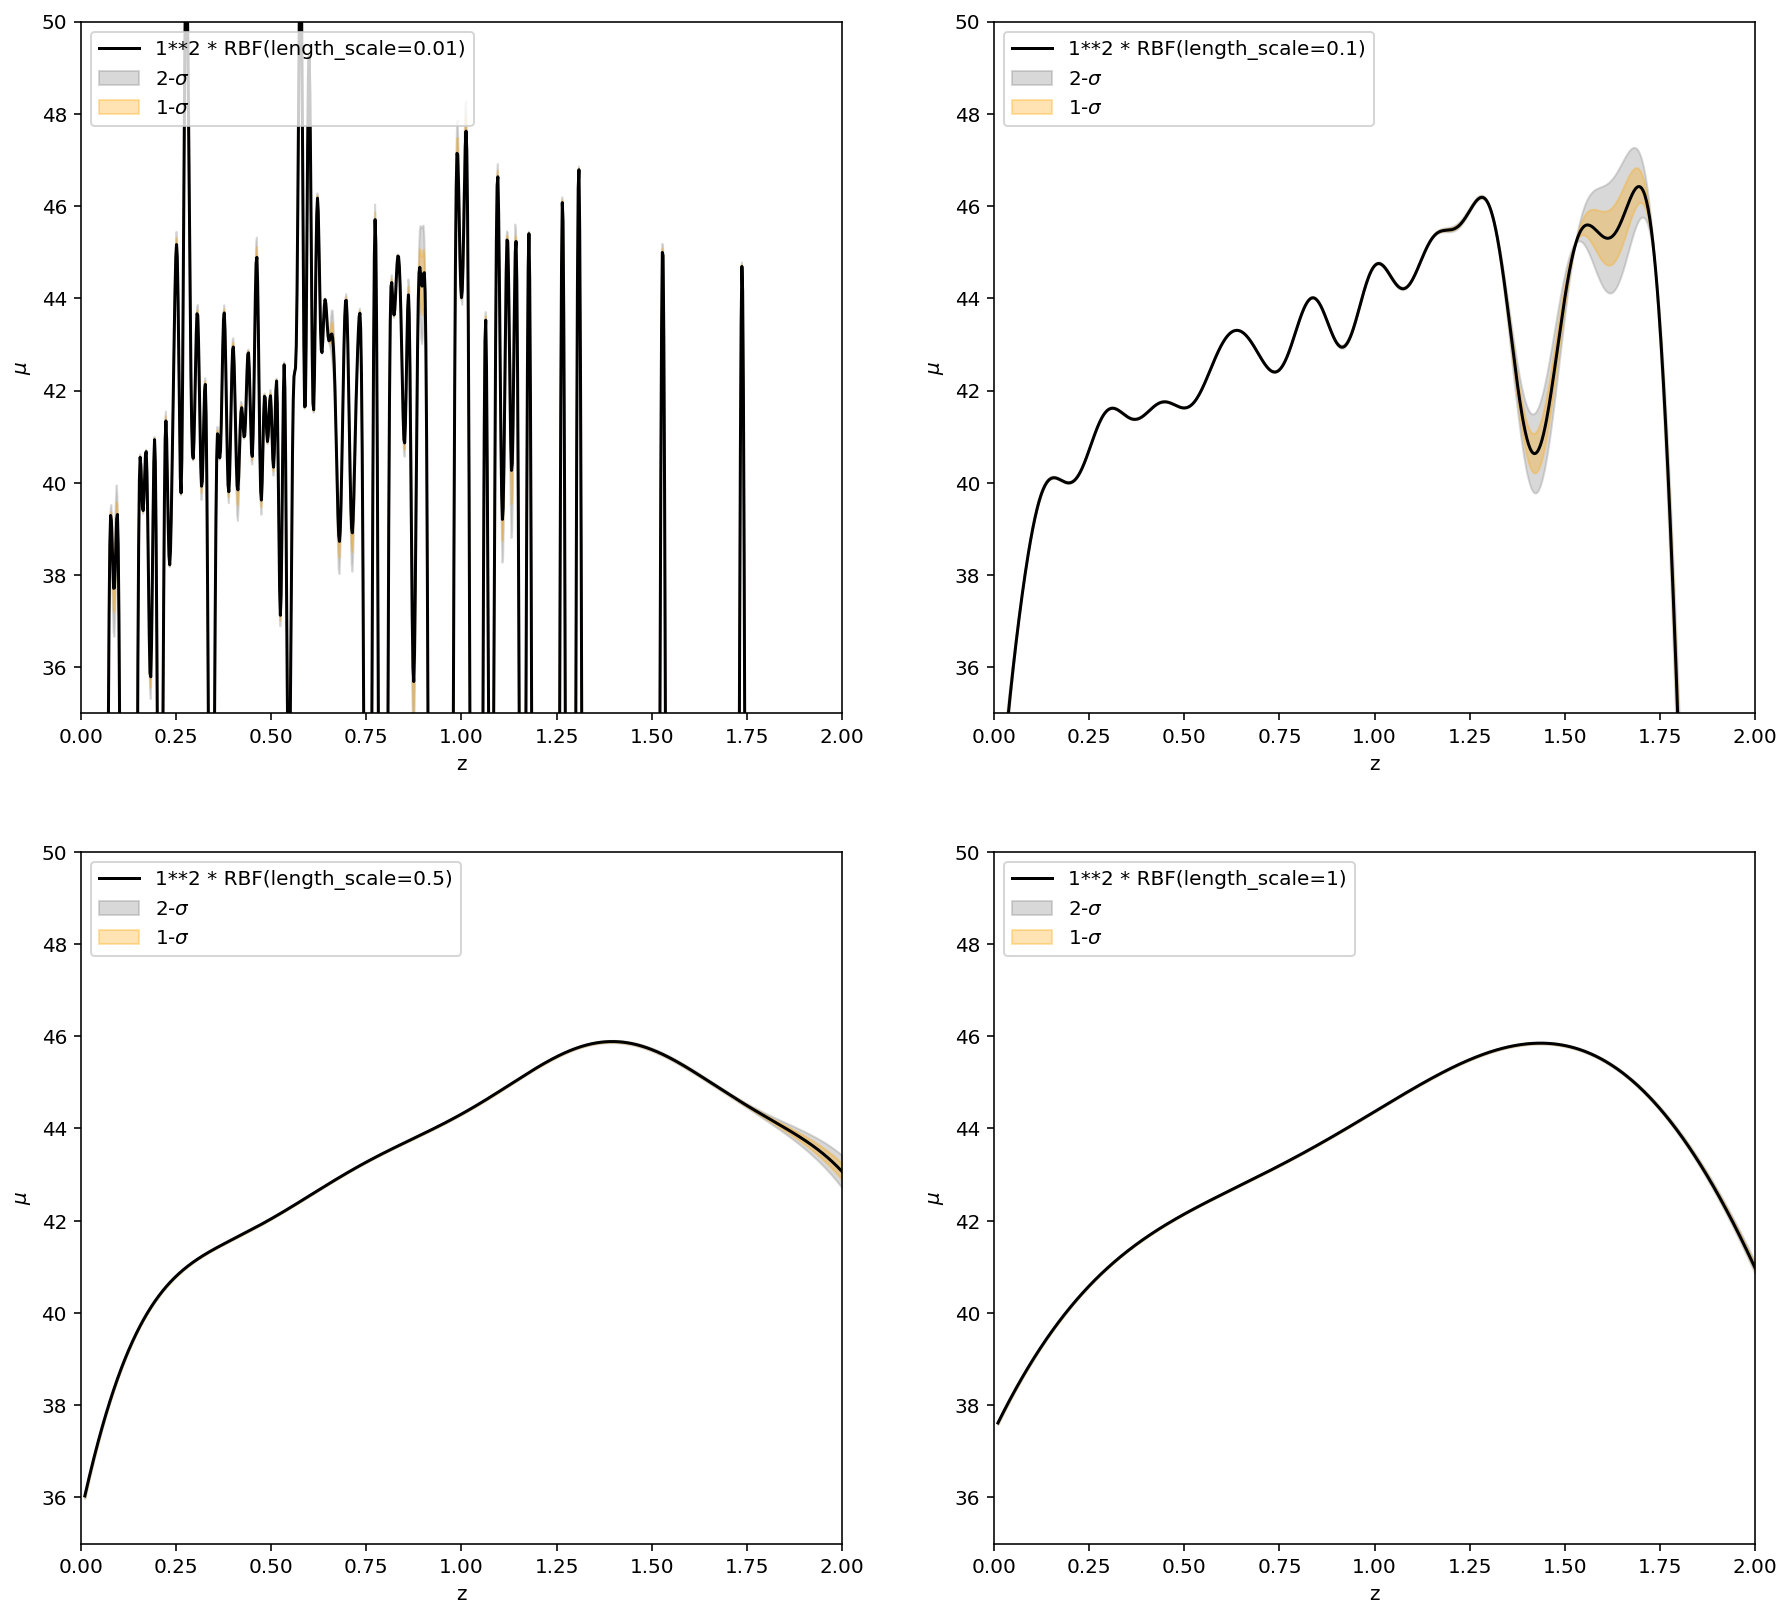

In [28]:
fig,axs = plt.subplots(2,2, figsize=(15,14))
c_axs = np.concatenate(axs)

for kernel,ax in zip(kernel_s, c_axs):
    
    gaussian_process = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=(dmu / dataset_corr_[:, 1])**2)  # , random_state=0, normalize_y=True
    gaussian_process.fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1])
    
    mu_pred_gp1, mu_pred_gp1_err = gaussian_process.predict(z[:, None], return_std=True)
    
    ax.plot(z, mu_pred_gp1, label=str(kernel), c='black')
    
    ax.fill_between(z, mu_pred_gp1 - 2 * mu_pred_gp1_err, mu_pred_gp1 + 2 * mu_pred_gp1_err, color='gray', alpha=0.3, label='2-$\sigma$')
    ax.fill_between(z,  mu_pred_gp1 - mu_pred_gp1_err, mu_pred_gp1 + mu_pred_gp1_err, color='orange', alpha=0.3, label='1-$\sigma$')

    
    ax.set_xlabel("z")
    ax.set_ylabel("$\mu$")
    ax.legend(loc='upper left', fontsize = 'medium')
    ax.set_xlim(0,2)
    ax.set_ylim(35,50)

## Cross validation

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fir it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy?

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

### Curve fit

In [98]:
def fit(z, Om0, H0): 
    
    if Om0 >0: 
    
        c = FlatLambdaCDM(H0, Om0)
    
        return c.distmod(z).value
    
    return 0

In [99]:
params, cov = curve_fit(fit, dataset_corr_[:, 0], dataset_corr_[:, 1])

In [100]:
print("Om0:", params[0], "+/-", np.sqrt(cov[0, 0]))
print("H0:", params[1], "+/-", np.sqrt(cov[1, 1]))

Om0: 0.2773208697810656 +/- 0.2444401592303391
H0: 70.37104164186249 +/- 7.4820011923283385


To see if these two values are correlated I will look at the correlation matrix (even if I am not sure it's a good estimator).

In [32]:
print(cov)

[[ 0.05975099 -1.67769502]
 [-1.67769502 55.98034184]]


There is a slight correlation term; to better quantify it I will now try to better investigate using emcee and Bayesian theory.

### Emcee sampling

In [33]:
def Model(par, z): 
    
    Om0, H0 = par
    
    if Om0 >0: 
    
        c = FlatLambdaCDM(H0, Om0)
    
        return c.distmod(z).value
    
    return 0



def log_prior(par):
    
    Om0, H0 = par
    
    if Om0 <0 or H0 > 100 or H0 <50 or Om0 >1: 
        return -np.inf
    
    else:
        return -np.log(50 * 1)


def log_likelihood(par, z, mu, err_mu):
    
    model = Model(par, z)
    
    return - 0.5 * np.sum(np.log(2*np.pi*err_mu**2) + ((mu - model) / err_mu)**2)


def log_posterior (par, z, mu, err_mu):
    
    lp = log_prior(par)
    
    if np.isfinite(lp):
        return lp + log_likelihood(par, z, mu, err_mu)
    
    else:
        return lp

In [34]:
ndim = 2  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses =  np.array([0.2, 70]) + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu))
sampler.run_mcmc(starting_guesses, nsteps, progress=True);

100%|███████████████████████████████████| 100000/100000 [23:54<00:00, 69.72it/s]


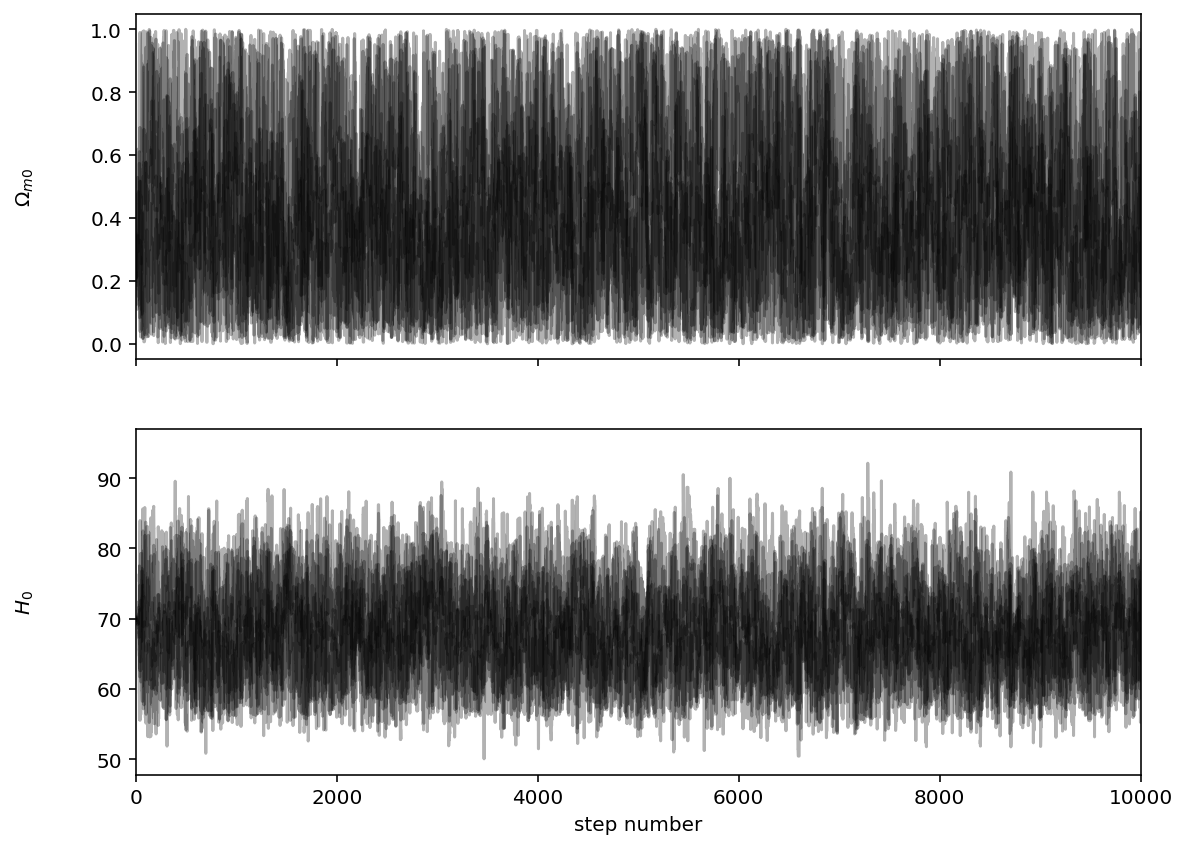

In [35]:
fig, axes = plt.subplots(2, figsize=(9, 7), sharex=True)

samples = sampler.get_chain()

labels = [r"$\Omega_{m0}$", r"$H_0$"]

for i in range(0, ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], c="k", alpha=0.3)
    ax.set_xlim(0, 10000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [36]:
tau = sampler.get_autocorr_time()
burn = 100

flat_samples = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True) 

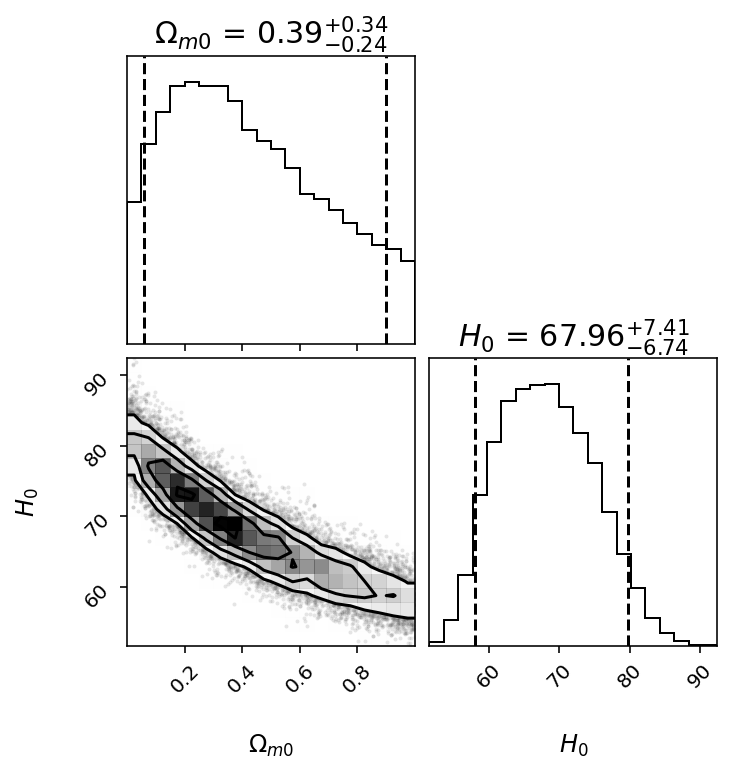

In [37]:
fig = corner.corner(
    flat_samples, labels=[r"$\Omega_{m0}$", r"$H_0$"], quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}, label_kwargs=dict(fontsize=12)
);

/Users/nicolegrillo/.local/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1341: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


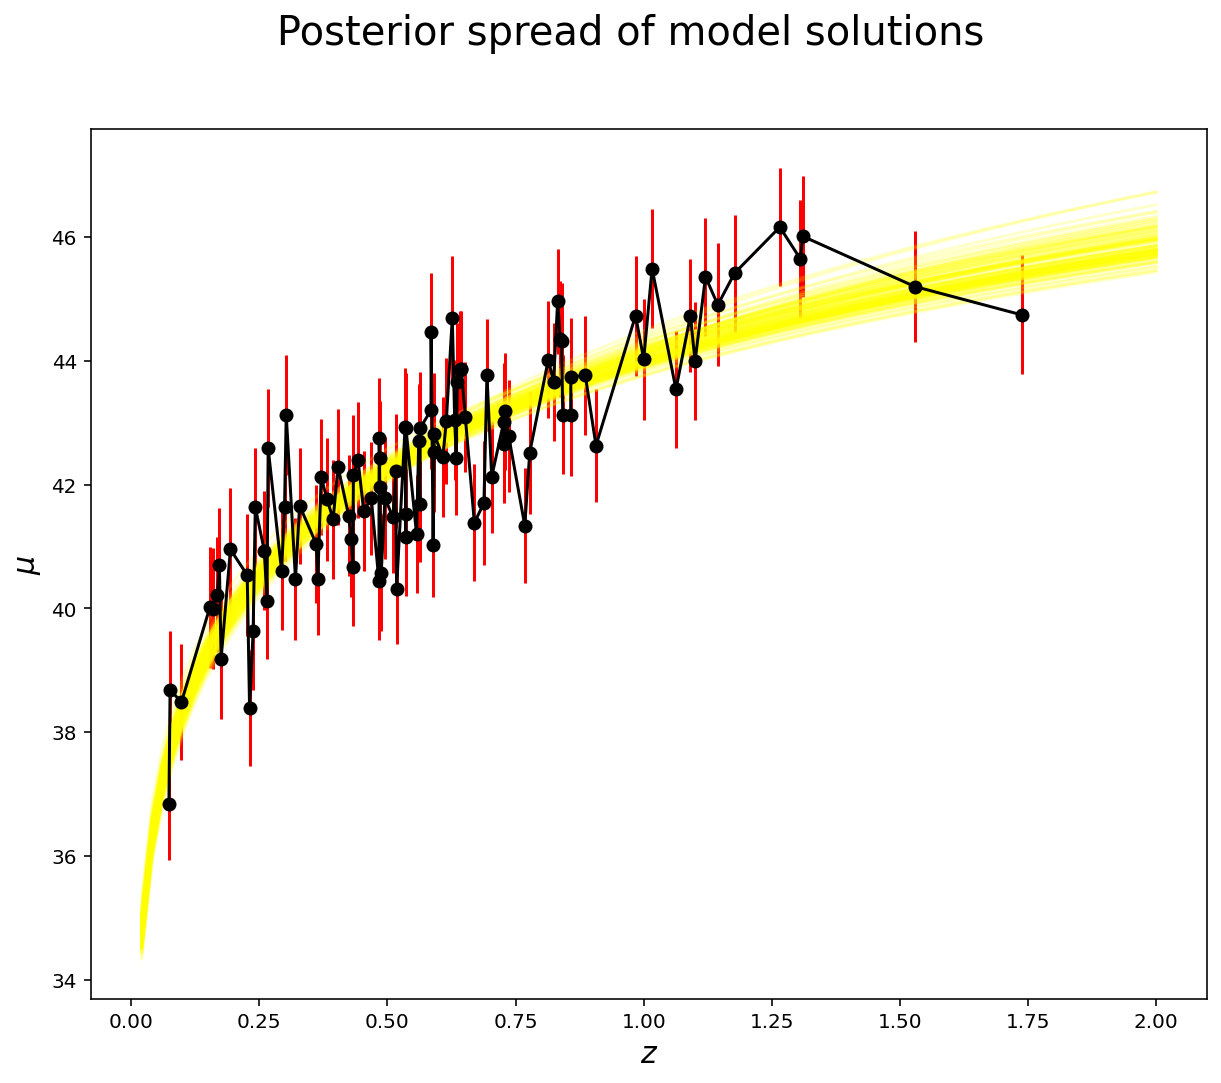

In [38]:
z_plot = np.linspace(0,2,100)

#plot section:

plt.figure(figsize=(10, 8))
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, marker='o', c="k", ecolor='red')
plt.xlabel("$z$", size=15)
plt.ylabel("$\mu$", size=15)
plt.suptitle("Posterior spread of model solutions", size=20);


for i in range(0, 100): 
    
    chosen_post = int(scipy.stats.uniform.rvs(0, len(flat_samples)))
    my_Model = Model(flat_samples[chosen_post], z_plot)
    
    plt.plot(z_plot, my_Model, alpha=0.2, c='yellow')

I here see how the two elements are correlated. Why? 

In [39]:
# try the nested sampling, do the same for DM models, and finally draw conclusions

## Nested sampling

In [40]:
# Define the dimensionality of the problem
ndim = 2

#define the TRANSFORM for the uniform prior (here uniform):

def ptform(theta):
    
    Om0, H0 = theta # unpack the parameters

    return (scipy.stats.uniform.ppf(Om0, 0, 1), scipy.stats.uniform.ppf(H0, 50, 100))

def loglikelihood_dynesty(theta):
    """
    The log-likelihood function.
    """
    return - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((dataset_corr_[:, 1] - Model(theta, dataset_corr_[:, 0])) / dmu)**2)

In [41]:
sampler = dynesty.NestedSampler(loglikelihood_dynesty, ptform, ndim)  # , nlive=1000
sampler.run_nested()
sresults = sampler.results

1872it [00:44, 41.91it/s, +500 | bound: 1 | nc: 1 | ncall: 18344 | eff(%): 13.293 | loglstar:   -inf < -133.215 <    inf | logz: -136.110 +/-  0.057 | dlogz:  0.001 >  0.509]


In [42]:
logZdynesty = sresults.logz[-1]        # value of logZ
logZerrdynesty = sresults.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [43]:
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty, logZerrdynesty))

Marginalised evidence (using static sampler) is -136.11002582519407 ± 0.1285945534703523


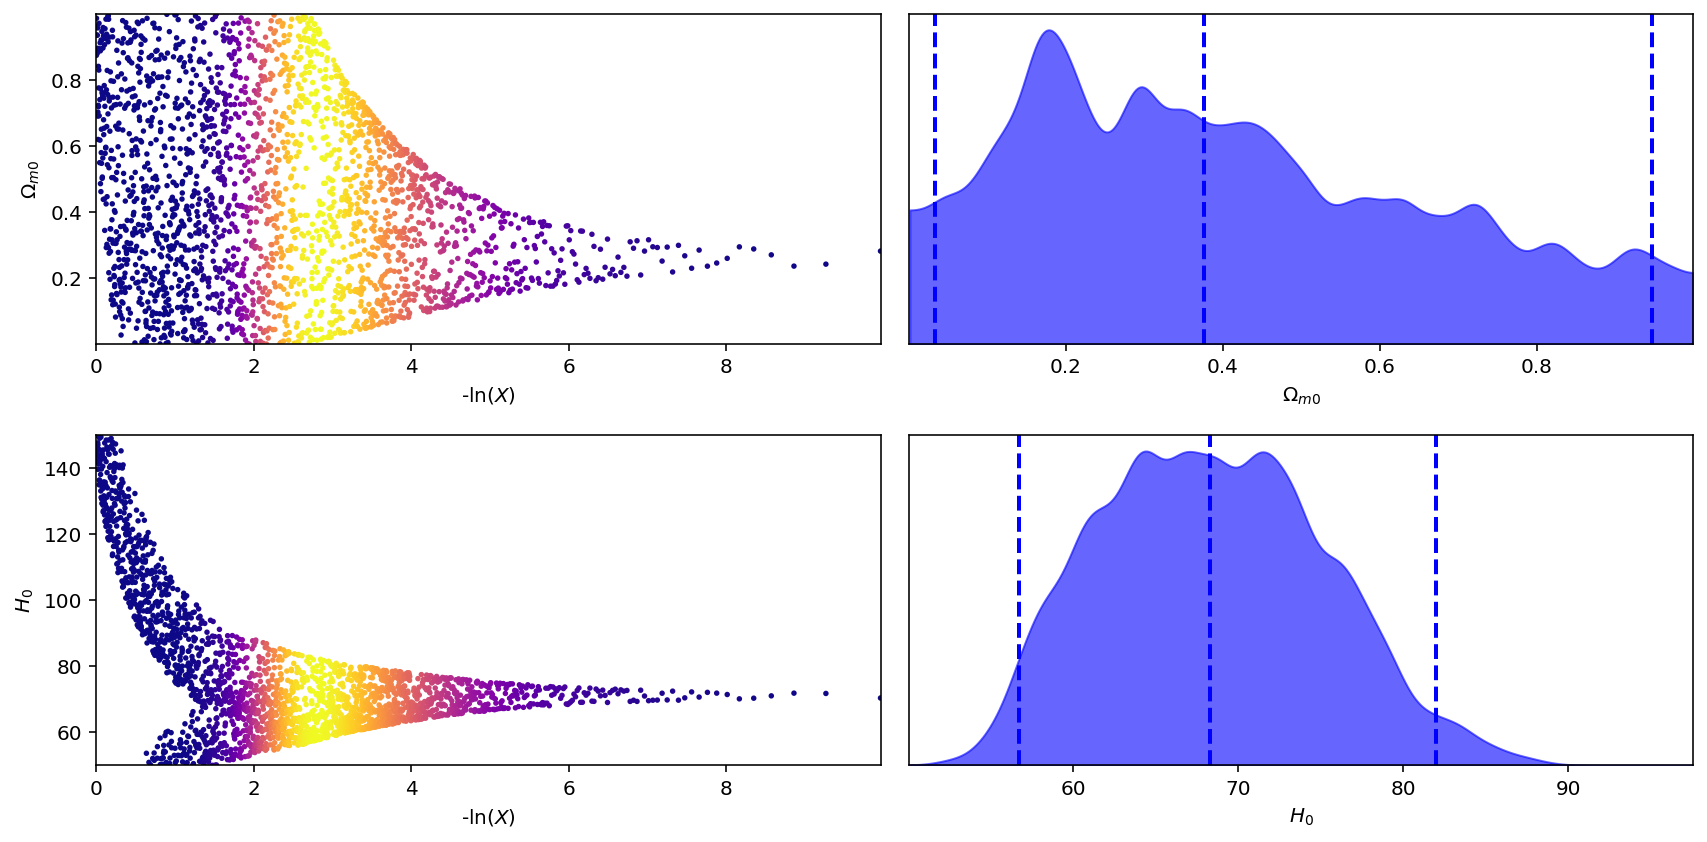

In [45]:
from dynesty import plotting as dyplot
tfig, taxes = dyplot.traceplot(sresults, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$\Omega_{m0}$")
taxes[0][1].set_xlabel("$\Omega_{m0}$")


taxes[1][0].set_xlabel("-$\\ln(X)$")
taxes[1][0].set_ylabel("$H_0$")
taxes[1][1].set_xlabel("$H_0$")


tfig.tight_layout()

In [47]:
weights = np.exp(sresults['logwt'] - sresults['logz'][-1])
postsamples = resample_equal(sresults.samples, weights)

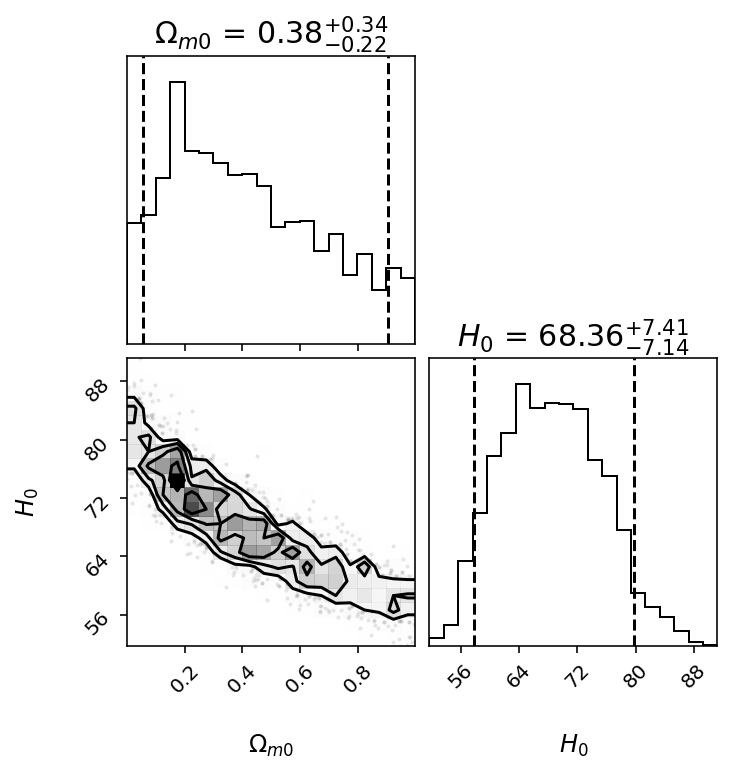

In [48]:
fig = corner.corner(
    postsamples, labels=labels, quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}, label_kwargs=dict(fontsize=12)
);

# Modelling without dark energy

In [83]:
def Model_1(par, z): 
    
    H0 = float(par)
    
    c = FlatLambdaCDM(H0=H0, Om0=1)
     
    return c.distmod(z).value

In [84]:
# Define the dimensionality of the problem
ndim = 1

#define the TRANSFORM for the uniform prior (here uniform):

def ptform_1(theta):
    
    H0 = theta # unpack the parameters

    return (scipy.stats.uniform.ppf(H0, 50, 100))

def loglikelihood_dynesty_1(theta):
    """
    The log-likelihood function.
    """
    return - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((dataset_corr_[:, 1] - Model_1(theta, dataset_corr_[:, 0])) / dmu)**2)

In [91]:
sampler_1 = dynesty.NestedSampler(loglikelihood_dynesty_1, ptform_1, ndim, nlive=1000)  # , nlive=1000
sampler_1.run_nested()
sresults_1 = sampler_1.results


3173it [00:37, 85.09it/s, +1000 | bound: 0 | nc: 1 | ncall: 23573 | eff(%): 18.487 | loglstar:   -inf < -134.236 <    inf | logz: -137.026 +/-  0.016 | dlogz:  0.001 >  1.009]


In [92]:
logZdynesty_1 = sresults_1.logz[-1]        # value of logZ
logZerrdynesty_1 = sresults_1.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [93]:
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty_1, logZerrdynesty_1))

Marginalised evidence (using static sampler) is -137.02572725127789 ± 0.11576560054562626


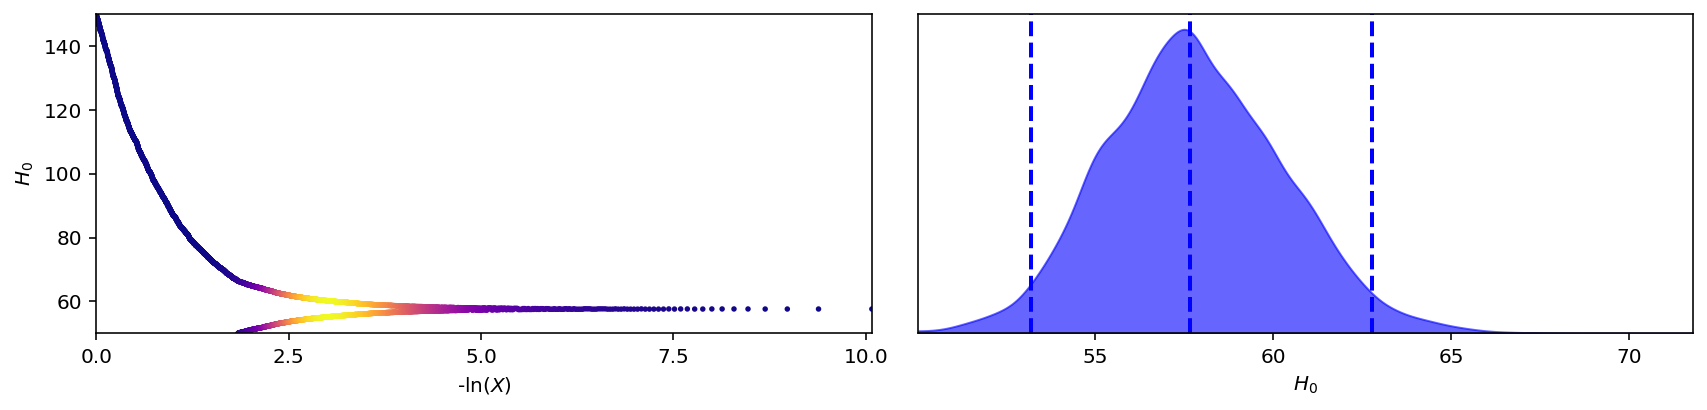

In [94]:
tfig, taxes = dyplot.traceplot(sresults_1, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$H_0$")
taxes[0][1].set_xlabel("$H_0$")


tfig.tight_layout()

What are the odds? I am quite sure there is evidence of dark energy in today's universe, but I don't know how this dataset was generated, so I will just find the evidence ratio and call it Bayes factor (prior ratio = 1 then). 

In [95]:
B_12 = np.exp(logZdynesty) / np.exp(logZdynesty_1)  # DE model vs not DE model

In [96]:
print("BR:", B_12)

BR: 2.49852716954053


The fact I obtained $B_{1,2} \sim 2$ indicates that a priori I cannot choose between one model or the other.

# Cloning data

In [138]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=(dmu / dataset_corr_[:, 1])**2)  # , random_state=0, normalize_y=True
gaussian_process.fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1]);

In [140]:
mu_pred, mu_sigma_pred = gaussian_process.predict(zs_cloning[:, None], return_std=True)
gpr_cloned = norm.rvs(mu_pred, mu_sigma_pred)  # each point can be seen as distributed as a gaussian

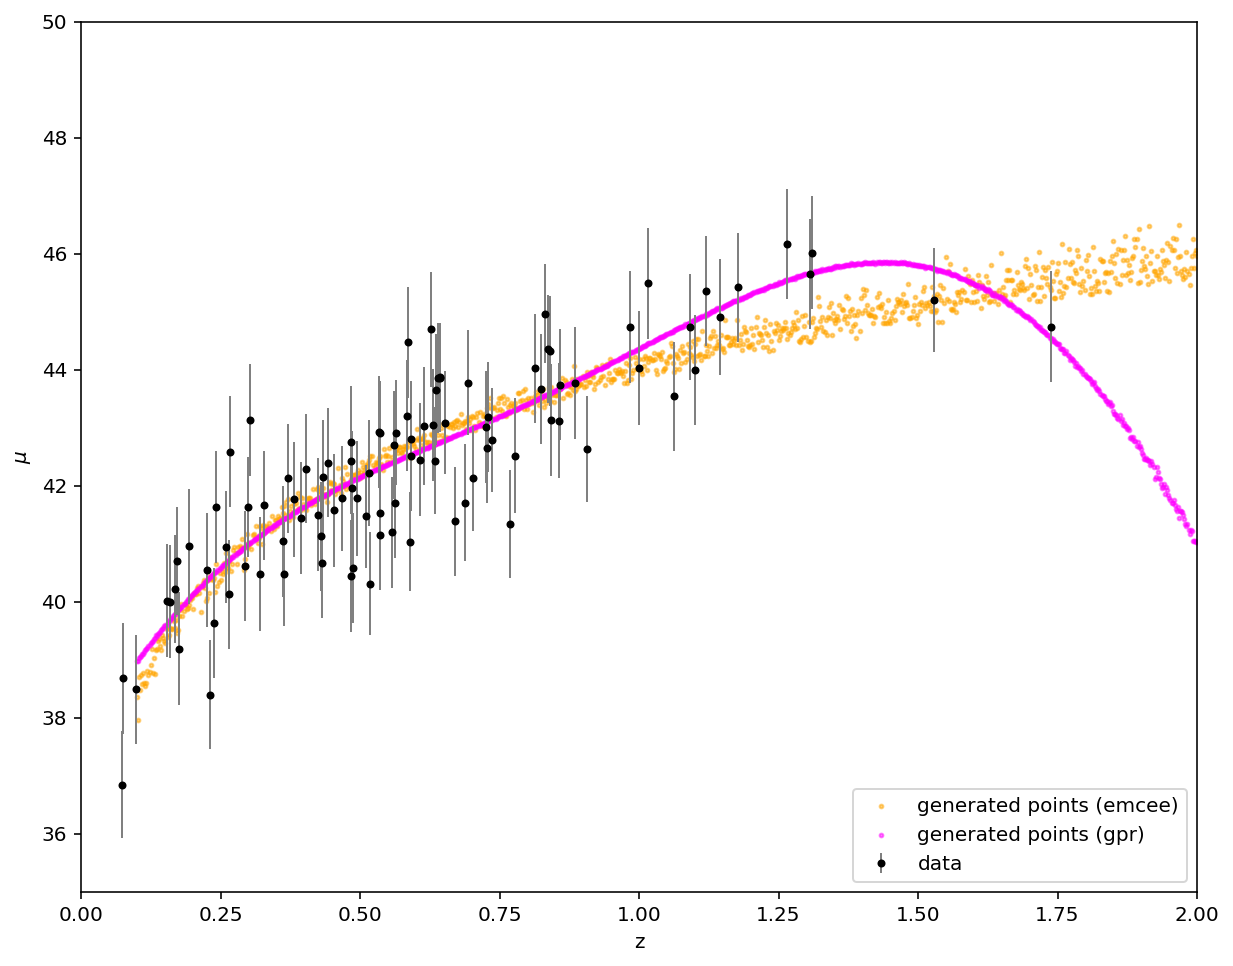

In [142]:
LCDM_cloned = []
zs_cloning = np.linspace(0.1, 2, 1000)  # uniform z distribution

mu_pred, mu_sigma_pred = gaussian_process.predict(zs_cloning[:, None], return_std=True)
gpr_cloned = norm.rvs(mu_pred, mu_sigma_pred)  # each point can be seen as distributed as a gaussian

for i in range(0, 1000):

    chosen_post = int(scipy.stats.uniform.rvs(0, len(flat_samples)))
    LCDM_cloned.append(Model(flat_samples[chosen_post], zs_cloning[i]))
    

plt.figure(figsize=(10, 8))
plt.scatter(zs_cloning, LCDM_cloned, s=3.5, c='orange', alpha=0.5, label='generated points (emcee)') 
plt.scatter(zs_cloning, gpr_cloned, s=3.5, c='magenta', alpha=0.5, label='generated points (gpr)')
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

I need to double check why the errors become so tiny from the GPR, but the exercise is over!